# import

In [8]:
import sys
sys.path.append("/glade/u/home/geethma/phd_research_home/functions")
from functions.imports import *

ERROR 1: PROJ: proj_create_from_database: Open of /glade/u/home/geethma/.conda/envs/wgh/share/proj failed


In [ ]:
# Paul Tol's colorblind-friendly palette
tol_colors = [
    "#332288", "#88CCEE", "#44AA99", "#117733",
    "#999933", "#DDCC77", "#CC6677", "#882255",
    "#AA4499", "#661100", "#6699CC", "#AA4466"
]

# SAVE REQUIRED DATA

## lat weighted mean  

In [150]:
def lat_weight_mean(maps):
    del_LWP_lat = maps.mean(dim=['lon'], skipna=True)
    weights = np.cos(np.deg2rad(del_LWP_lat.lat))
    weights.name = "weights"
    del_LWP_lat_weighted = del_LWP_lat.weighted(weights)
    del_LWP_mean = del_LWP_lat_weighted.mean(dim=['lat'], skipna=True)
    return del_LWP_mean

## global feedback function

In [11]:
def globalFB(var='map_dLWP4K'):
    from get_land_mask import get_land_mask
    wd  = '/glade/campaign/uwyo/wyom0131/delLWP/lats_15_40/'
    fns = np.sort(glob.glob(wd+'*ffv2.npz'))
    ensembles = []
    maps = []
    maps_o = []
    
    for i in range(len(fns)):  # 
        data = np.load(fns[i], allow_pickle=True)
        maps.append(xr.DataArray(
            data[var], 
            dims = ['lat', 'lon'], 
            coords={'lat': data['lat'], 'lon': data['lon']}
        ))
        land_mask = get_land_mask(data['lat'], data['lon'])[0]

        maps_o.append(xr.DataArray(
            data[var]*land_mask, 
            dims = ['lat', 'lon'], 
            coords={'lat': data['lat'], 'lon': data['lon']}
        ))
        
        ensembles.append(data['ensn'])
        
    
    maps = xr.DataArray(
        maps, 
        dims = ['runs', 'lat', 'lon'],
        coords={'runs': ensembles, 'lat': data['lat'], 'lon': data['lon']}
    )
    
    maps_o = xr.DataArray(
        maps_o, 
        dims = ['runs', 'lat', 'lon'],
        coords={'runs': ensembles, 'lat': data['lat'], 'lon': data['lon']}
    )
    
    del_LWP_lat = maps.mean(dim=['lon'], skipna=True)
    weights = np.cos(np.deg2rad(del_LWP_lat.lat))
    weights.name = "weights"
    del_LWP_lat_weighted = del_LWP_lat.weighted(weights)
    del_LWP_mean = del_LWP_lat_weighted.mean(dim=['lat'], skipna=True)

    return del_LWP_mean, maps, maps_o

In [8]:
wd  = '/glade/campaign/uwyo/wyom0131/delLWP/lats_15_40/'
fns = np.sort(glob.glob(wd+'*ffv2.npz'))
ensembles = []
maps = []

for i in range(1):  # 
    data = np.load(fns[i], allow_pickle=True)

In [10]:
data.files

['ensn',
 'adj_lwppipd',
 'dNdpipdadjnd',
 'lon',
 'lat',
 'dLWP4K',
 'map_dLWP4K',
 'map_LWP_PD_f',
 'map_dSWCF4K',
 'map_SWCF_PD_f',
 'map_dPE4K',
 'map_PE_PD_f',
 'allow_pickle']

## PD, PI, SST4K free running and nudged functions

In [13]:
def get_nudged_PPE(fnum,varnm='FSDS',type_run='PD'):
    fnums=str(fnum).zfill(3)

    #/glade/campaign/uwyo/wyom0124/daily/PD/PPE_rerun_ensemble_PD.030/atm/hist/PPE_rerun_ensemble_PD.030.cam.h0.2017-09.nc
    WD='/glade/campaign/uwyo/wyom0124/daily/'+type_run+'/PPE_rerun_ensemble_'+type_run+'.'
    fn=WD+fnums+'/atm/hist/PPE_rerun_ensemble_'+type_run+'.'+fnums+'.cam.h1.*.nc'
    import netCDF4 as nc
    from datetime import datetime
    print(fn)
    f = nc.MFDataset(fn, 'r')
    tvar = 'time'
    tt = f.variables[tvar]
    latvar = 'lat'
    lonvar = 'lon'
    lat = f.variables[latvar][:]
    lon = f.variables[lonvar][:]
    Z = f.variables[varnm][:]
    lon[lon > 180] = lon[lon > 180]-360
    ind = np.argsort(lon)
    lon = lon[ind]
    Z = 1.*Z[:,:,ind]
    ind2 = np.argsort(lat)
    Z = 1.*Z[:,ind2,:]
    lat = lat[ind2]
    #import numpy.ma
    #Z=1.*Z.filled(fill_value=NaN)
    return [Z, lat, lon,tt]

In [9]:
def get_free_PPE(fnum,varnm='FSDS',type_run='PD'):
    fnums=str(fnum).zfill(3)
    WD='/glade/campaign/cgd/projects/ppe/cam_ppe/rerun_PPE_250/'+type_run+'/'+type_run+'_timeseries/'
    fn=WD+'PPE_250_ensemble_'+type_run+'.'+fnums+'/atm/hist/cc_PPE_250_ensemble_'+type_run+'.'+fnums+'.h1.'+varnm+'.nc'
    if fnum==175:
        fn='/glade/campaign/cgd/projects/ppe/cam_ppe/PPE_250/control/control_timeseries/PPE_250_ensemble.175/atm/hist/cc_PPE_250_ensemble.'+fnums+'.h1.'+varnm+'.nc'
    import netCDF4 as nc
    from datetime import datetime
    #print(fn)
    f = nc.Dataset(fn, 'r')
    tvar = 'time'
    tt = f.variables[tvar]
    latvar = 'lat'
    lonvar = 'lon'
    lat = f.variables[latvar][:]
    lon = f.variables[lonvar][:]
    Z = f.variables[varnm][:]
    lon[lon > 180] = lon[lon > 180]-360
    ind = np.argsort(lon)
    lon = lon[ind]
    Z = 1.*Z[:,:,ind]
    ind2 = np.argsort(lat)
    Z = 1.*Z[:,ind2,:]
    lat = lat[ind2]
    import numpy.ma
    Z=1.*Z.filled(fill_value=np.NaN)
    return [Z, lat, lon,tt]

## get the maps for time mean

In [40]:
# dLWPmean, dLWPmap, dLWPmap_o = globalFB('map_dLWP4K')

In [41]:
# dLWPmean.runs

In [42]:
# np.savez('data/runs.npz', runs=dLWPmean.runs.data)

In [39]:
def PPE_maps(varnm, type='free'):
    from get_land_mask import get_land_mask
    # maps = []
    maps_o = []
    ensembles = []
    fi = np.load('data/runs.npz')
    ens = list(fi['runs'])
    if 175 in ens:
        ens.remove(175)
    for en in ens:
        print(en)
        if type=='free':
            Z, lat, lon,tt = get_free_PPE(en, varnm=varnm)
        if type=='nudged':
            Z, lat, lon,tt = get_nudged_PPE(en, varnm=varnm)
        Z = np.nanmean(Z, axis=0)
        land_mask = get_land_mask(lat, lon)[0]
        # maps.append(Z)
        maps_o.append(Z*land_mask)
        ensembles.append(en)

    return maps_o, ensembles, lat, lon


## LWP

In [95]:
fn = '/glade/campaign/cgd/projects/ppe/cam_ppe/rerun_PPE_250/PD/PD_timeseries/PPE_250_ensemble_PD.000/atm/hist/cc_PPE_250_ensemble_PD.000.h0.TGCLDLWP.nc'
f = nc.Dataset(fn, 'r')
print(f['TGCLDLWP'])

<class 'netCDF4._netCDF4.Variable'>
float32 TGCLDLWP(time, lat, lon)
    _FillValue: nan
    units: kg/m2
    long_name: Total grid-box cloud liquid water path
    cell_methods: time: mean
unlimited dimensions: 
current shape = (36, 192, 288)
filling on


In [96]:
maps_o, ensembles, lat, lon = PPE_maps(varnm='TGCLDLWP', type='free')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
23
24
25
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
176
177
178
179
180
181
182
183
184
185
186
187
189
190
193
194
195
196
197
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262


In [97]:
np.savez('data/PD_freeRun_lwp_maps_o.npz', 
         maps_o=maps_o, 
         runs=ensembles, 
         lat=lat, 
         lon=lon)

## PRECIPITATION

In [92]:
fn = '/glade/campaign/cgd/projects/ppe/cam_ppe/rerun_PPE_250/PD/PD_timeseries/PPE_250_ensemble_PD.000/atm/hist/cc_PPE_250_ensemble_PD.000.h1.PRECC.nc'
f = xr.open_dataset(fn)
print(f['PRECC'])

<xarray.DataArray 'PRECC' (time: 1110, lat: 192, lon: 288)>
[61378560 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 0001-01-01 00:00:00 ... 0004-01-14 12:00:00
Attributes:
    units:         m/s
    long_name:     Convective precipitation rate (liq + ice)
    cell_methods:  time: mean


In [18]:
from get_land_mask import get_land_mask
ensembles = []
p_maps = []
p_maps_o = []
ens = list(w500_maps_o.runs.data.copy())
if 175 in ens:
    ens.remove(175)
for en in ens:
    print(en)
    Z, lat, lon,tt = get_free_PPE(en, varnm='PRECC')
    Z = np.nanmean(Z, axis=0)
    land_mask = get_land_mask(lat, lon)[0]
    p_maps.append(Z)
    p_maps_o.append(Z*land_mask)
    ensembles.append(en)
    # print(np.shape(w500_maps))
f_lat = lat
f_lon = lon

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
23
24
25
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
176
177
178
179
180
181
182
183
184
185
186
187
189
190
193
194
195
196
197
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262


In [19]:
from get_land_mask import get_land_mask
pl_maps = []
pl_maps_o = []
ens = list(w500_maps_o.runs.data.copy())
if 175 in ens:
    ens.remove(175)
for en in ens:
    print(en)
    Z, lat, lon,tt = get_free_PPE(en, varnm='PRECL')
    Z = np.nanmean(Z, axis=0)
    land_mask = get_land_mask(lat, lon)[0]
    pl_maps.append(Z)
    pl_maps_o.append(Z*land_mask)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
23
24
25
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
176
177
178
179
180
181
182
183
184
185
186
187
189
190
193
194
195
196
197
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262


In [27]:
prc_maps_o = np.add(p_maps_o, pl_maps_o)

In [28]:
np.shape(prc_maps_o)

(253, 192, 288)

In [29]:
np.savez('data/PD_freeRun_prc_maps_o.npz', 
         prc_maps_o=prc_maps_o, 
         runs=ensembles, 
         lat=f_lat, 
         lon=f_lon)

## WVP

In [44]:
fn = '/glade/campaign/cgd/projects/ppe/cam_ppe/rerun_PPE_250/PD/PD_timeseries/PPE_250_ensemble_PD.000/atm/hist/cc_PPE_250_ensemble_PD.000.h0.TMQ.nc'
f = nc.Dataset(fn, 'r')

In [46]:
f['TMQ']

<class 'netCDF4._netCDF4.Variable'>
float32 TMQ(time, lat, lon)
    _FillValue: nan
    units: kg/m2
    long_name: Total (vertically integrated) precipitable water
    cell_methods: time: mean
unlimited dimensions: 
current shape = (36, 192, 288)
filling on

In [43]:
maps_o, ensembles, lat, lon = PPE_maps(varnm='TMQ', type='free')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
23
24
25
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
176
177
178
179
180
181
182
183
184
185
186
187
189
190
193
194
195
196
197
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262


In [47]:
np.savez('data/PD_freeRun_wvp_maps_o.npz', 
         maps_o=maps_o, 
         runs=ensembles, 
         lat=lat, 
         lon=lon)

# ∆LWP

In [12]:
dLWPmean, dLWPmap, dLWPmap_o = globalFB('map_dLWP4K')

In [6]:
np.shape(dLWPmap)

(254, 192, 288)

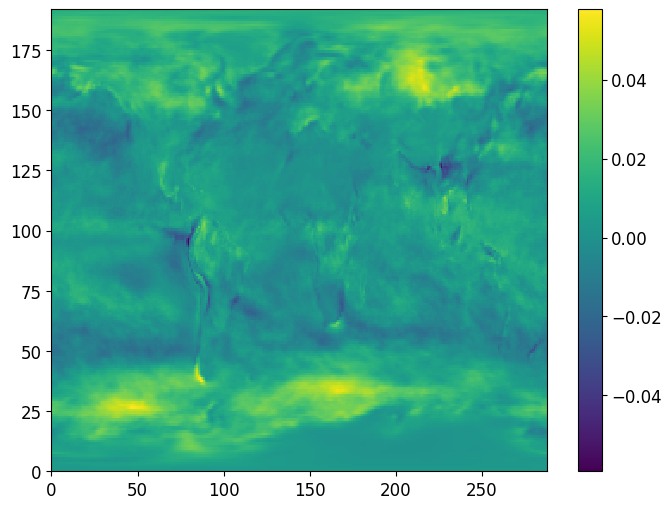

In [19]:
plt.pcolormesh(dLWPmap[0])
plt.colorbar()

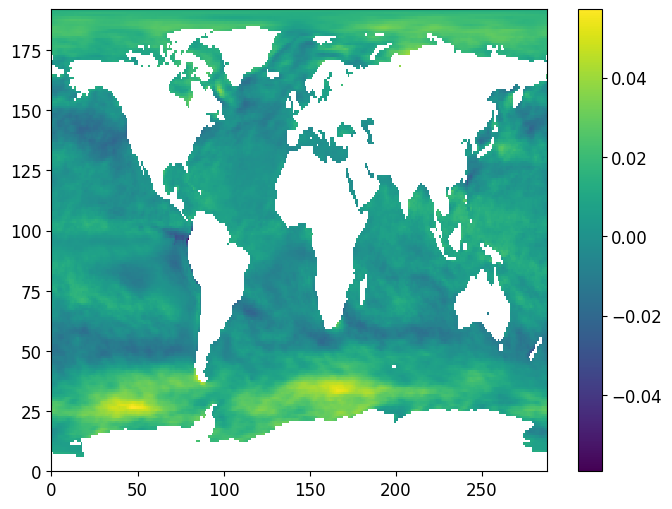

In [18]:
plt.pcolormesh(dLWPmap_o[0])
plt.colorbar()

# w500

In [48]:
type_run = 'PD'
fnum = 0
varnm = 'OMEGA500'
fnums=str(fnum).zfill(3)
WD='/glade/campaign/cgd/projects/ppe/cam_ppe/rerun_PPE_250/'+type_run+'/'+type_run+'_timeseries/'
fn=WD+'PPE_250_ensemble_'+type_run+'.'+fnums+'/atm/hist/cc_PPE_250_ensemble_'+type_run+'.'+fnums+'.h1.'+varnm+'.nc'

In [49]:
import netCDF4 as nc
from datetime import datetime
#print(fn)
f = nc.Dataset(fn, 'r')

In [51]:
f['OMEGA500']

<class 'netCDF4._netCDF4.Variable'>
float32 OMEGA500(time, lat, lon)
    _FillValue: nan
    units: Pa/s
    long_name: Vertical velocity at 500 mbar pressure surface
    cell_methods: time: mean
unlimited dimensions: 
current shape = (1110, 192, 288)
filling on

In [59]:
Z, lat, lon,tt = get_free_PPE(0, type_run='PD', varnm='OMEGA500')

In [40]:
Z.shape

(36, 192, 288)

In [13]:
from get_land_mask import get_land_mask
ensembles = []
w500_maps = []
w500_maps_o = []
ens = list(dLWPmean.runs.data.copy())
if 175 in ens:
    ens.remove(175)
for en in ens:
    print(en)
    Z, lat, lon,tt = get_free_PPE(en, varnm='OMEGA500')
    Z = np.nanmean(Z, axis=0)
    land_mask = get_land_mask(lat, lon)[0]
    w500_maps.append(Z)
    w500_maps_o.append(Z*land_mask)
    ensembles.append(en)
    # print(np.shape(w500_maps))
f_lat = lat
f_lon = lon

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
23
24
25
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
176
177
178
179
180
181
182
183
184
185
186
187
189
190
193
194
195
196
197
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262


In [14]:
w500_maps = xr.DataArray(
    w500_maps,
    dims = ['runs', 'lat', 'lon'],
    coords={'runs': ensembles, 'lat': f_lat, 'lon': f_lon}
)

In [15]:
w500_maps_o = xr.DataArray(
    w500_maps_o,
    dims = ['runs', 'lat', 'lon'],
    coords={'runs': ensembles, 'lat': f_lat, 'lon': f_lon}
)

In [54]:
np.shape(w500_maps)

(3, 192, 288)

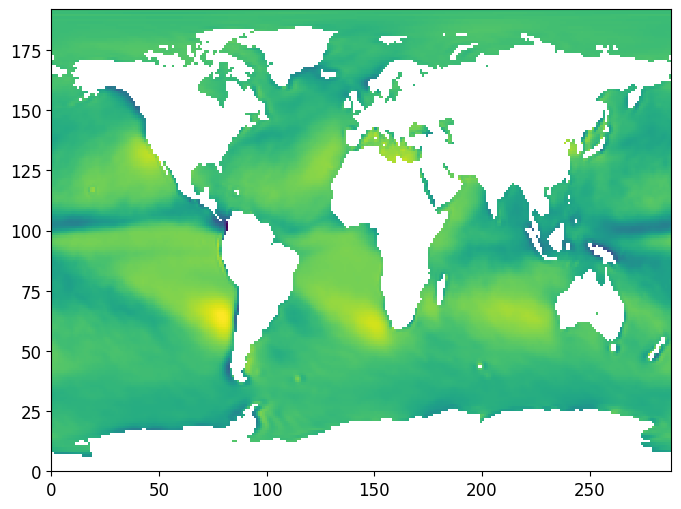

In [55]:
plt.pcolormesh(w500_maps_o[0])

# plot function

In [32]:
from numpy import *
from sklearn.metrics import r2_score, mean_squared_error
def plot_sns_linear(x, y, color='r'):
    # Remove NaN values
    ind = ~np.isnan(x * y)
    x = x[ind]
    y = y[ind]
    
    # Get 95% of the data
    lower_percentile = np.percentile(y, 2.5)
    upper_percentile = np.percentile(y, 97.5)
    mask = (y >= lower_percentile) & (y <= upper_percentile)
    x = x[mask]
    y = y[mask]
    
    # Create bins
    xbins = np.percentile(x, np.linspace(0, 100, 10))
    
    # Plot regression line
    x_bins = stats.binned_statistic(x, x, bins=xbins)[0]
    y_bins = stats.binned_statistic(x, y, bins=xbins)[0]
    sns.regplot(x=x_bins, y=y_bins, ci=95, color=color, scatter_kws={'s': 0}, lowess=False, truncate=False)
    
    # Plot scatter points
    # plt.scatter(x, y, 4, color='0.6', zorder=-10)
    
    # Plot error bars
    # plt.errorbar(
    #     stats.binned_statistic(x, x, bins=xbins)[0],
    #     stats.binned_statistic(x, y, bins=xbins)[0],
    #     xerr=stats.binned_statistic(x, x, bins=xbins, statistic='std')[0],
    #     yerr=stats.binned_statistic(x, y, bins=xbins, statistic='std')[0],
    #     fmt='sk', capsize=2
    # )
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Calculate R² (coefficient of determination)
    r_squared = r_value**2
    
    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y, np.polyval([slope, intercept], x)))
    
    # Add regression line equation and statistics to the plot
    # equation = f'y = {slope:.4f}x + {intercept:.4f}'
    # stats_text = f'R² = {r_squared:.4f}\nRMSE = {rmse:.4f}\np-value = {p_value:.4f}'
    # plt.annotate(equation + '\n' + stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
    #              va='top', ha='left', bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))
    
    return r_squared, rmse, p_value

# plot PD precipitation with w500(free running)

In [110]:
file = np.load('data/PD_freeRun_prc_maps_o.npz')
# convert np array to xarrays
prc_maps_o = xr.DataArray(
    file['prc_maps_o'], 
    dims = ['runs', 'lat', 'lon'],
    coords={'runs': file['runs'], 
            'lat': file['lat'], 
            'lon': file['lon']}
)

In [111]:
# Select latitude ranges separately and combine them
maps_o_sh = prc_maps_o.sel(lat=slice(-80, -50))
maps_o_nh = prc_maps_o.sel(lat=slice(50, 80))

# Concatenate the subsets along the latitude dimension
prc_maps_o_midlats = xr.concat([maps_o_sh, maps_o_nh], dim="lat")

In [113]:
# Select latitude ranges separately and combine them
maps_o_sh = w500_maps_o.sel(lat=slice(-80, -50))
maps_o_nh = w500_maps_o.sel(lat=slice(50, 80))

# Concatenate the subsets along the latitude dimension
w500_maps_o_midlats = xr.concat([maps_o_sh, maps_o_nh], dim="lat")

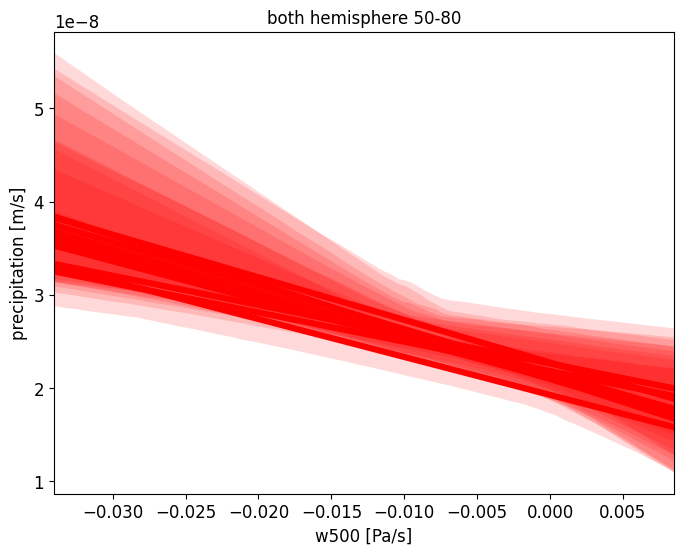

In [115]:
for i in range(10):
    plot_sns_linear(np.ravel(w500_maps_o_midlats[i]), np.ravel(prc_maps_o_midlats[i]))
    plt.xlabel('w500 [Pa/s]')
    plt.ylabel('precipitation [m/s]')
    plt.title('both hemisphere 50-80')

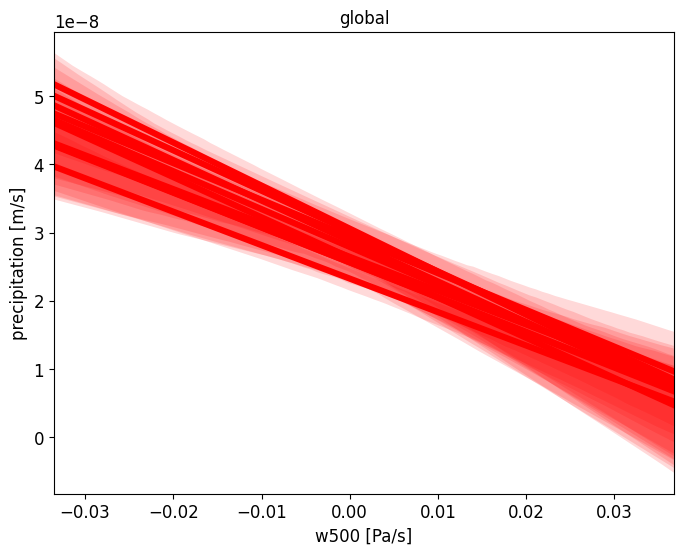

In [112]:
for i in range(10):
    plot_sns_linear(np.ravel(w500_maps_o[i]), np.ravel(prc_maps_o[i]))
    plt.xlabel('w500 [Pa/s]')
    plt.ylabel('precipitation [m/s]')
    plt.title('global')

# plot PD LWP with Precipitation

In [94]:
file = np.load('data/PD_freeRun_prc_maps_o.npz')
# convert np array to xarrays
prc_maps_o = xr.DataArray(
    file['prc_maps_o'], 
    dims = ['runs', 'lat', 'lon'],
    coords={'runs': file['runs'], 
            'lat': file['lat'], 
            'lon': file['lon']}
)

In [117]:
file = np.load('data/PD_freeRun_lwp_maps_o.npz')
lwp_maps_o = xr.DataArray(
    file['maps_o'], 
    dims = ['runs', 'lat', 'lon'],
    coords={'runs': file['runs'], 
            'lat': file['lat'], 
            'lon': file['lon']}
)

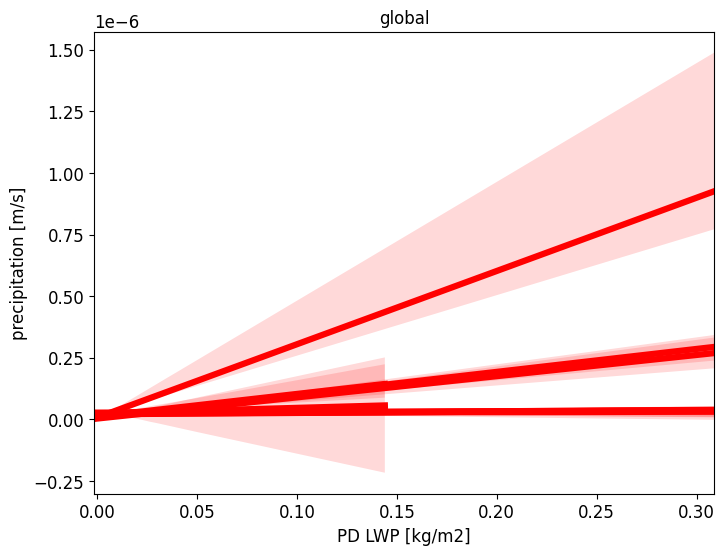

In [116]:
for i in range(10):
    plot_sns_linear(np.ravel(lwp_maps_o[i]), np.ravel(prc_maps_o[i]))
    plt.xlabel('PD LWP [kg/m2]')
    plt.ylabel('precipitation [m/s]')
    plt.title('global')

In [118]:
# Select latitude ranges separately and combine them
maps_o_sh = lwp_maps_o.sel(lat=slice(-80, -50))
maps_o_nh = lwp_maps_o.sel(lat=slice(50, 80))

# Concatenate the subsets along the latitude dimension
lwp_maps_o_midlats = xr.concat([maps_o_sh, maps_o_nh], dim="lat")

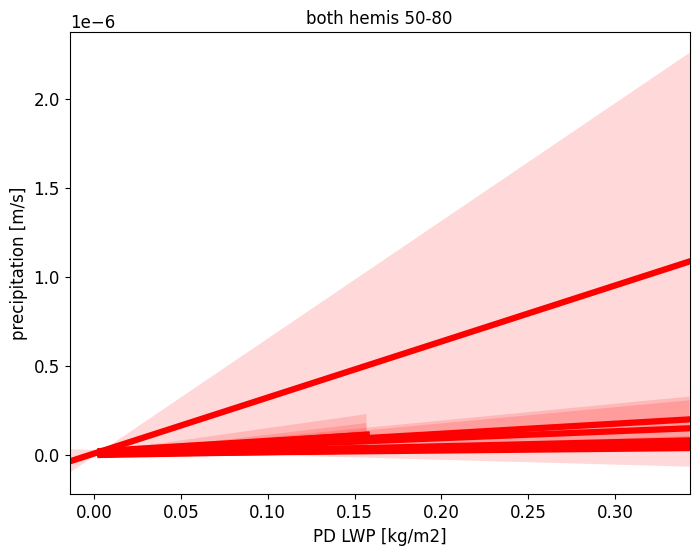

In [120]:
for i in range(10):
    plot_sns_linear(np.ravel(lwp_maps_o_midlats[i]), np.ravel(prc_maps_o_midlats[i]))
    plt.xlabel('PD LWP [kg/m2]')
    plt.ylabel('precipitation [m/s]')
    plt.title('both hemis 50-80')

# ∆LWP with PD LWP

In [101]:
file = np.load('data/PD_freeRun_lwp_maps_o.npz')
lwp_maps_o = xr.DataArray(
    file['maps_o'], 
    dims = ['runs', 'lat', 'lon'],
    coords={'runs': file['runs'], 
            'lat': file['lat'], 
            'lon': file['lon']}
)

In [103]:
common_members = np.intersect1d(lwp_maps_o['runs'], dLWPmap_o['runs'])

# Select only the common members from both datasets
lwp_maps_o = lwp_maps_o.sel(runs=common_members)
dLWPmap_o = dLWPmap_o.sel(runs=common_members)

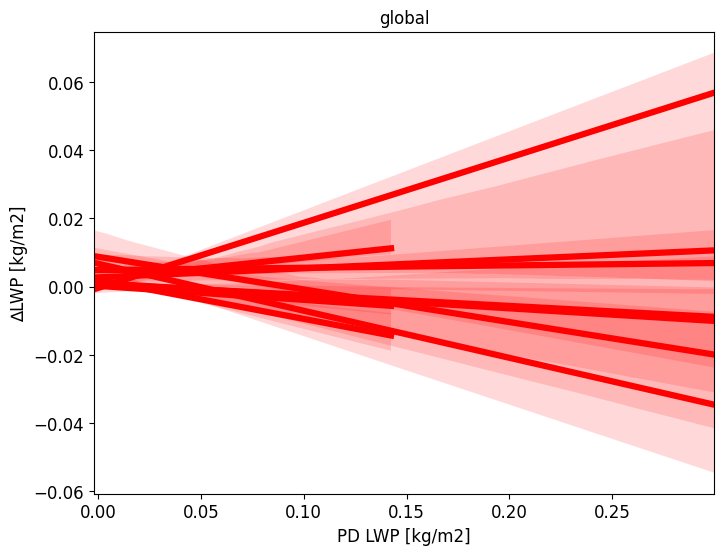

In [121]:
for i in range(10):
    plot_sns_linear(np.ravel(lwp_maps_o[i]), np.ravel(dLWPmap_o[i]))
    plt.xlabel('PD LWP [kg/m2]')
    plt.ylabel('∆LWP [kg/m2]')
    plt.title('global')

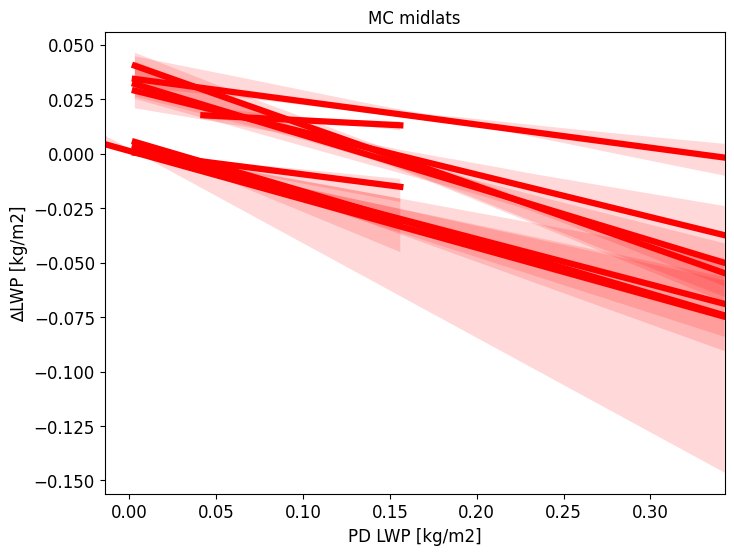

In [122]:
# Select latitude ranges separately and combine them
maps_o_sh = dLWPmap_o.sel(lat=slice(-80, -50))
maps_o_nh = dLWPmap_o.sel(lat=slice(50, 80))

# Concatenate the subsets along the latitude dimension
dLWPmap_o_midlats = xr.concat([maps_o_sh, maps_o_nh], dim="lat")

common_members = np.intersect1d(lwp_maps_o_midlats['runs'], dLWPmap_o_midlats['runs'])
lwp_maps_o_midlats = lwp_maps_o_midlats.sel(runs=common_members)
dLWPmap_o_midlats = dLWPmap_o_midlats.sel(runs=common_members)

for i in range(10):
    plot_sns_linear(np.ravel(lwp_maps_o_midlats[i]), np.ravel(dLWPmap_o_midlats[i]))
    plt.xlabel('PD LWP [kg/m2]')
    plt.ylabel('∆LWP [kg/m2]')
    plt.title('MC midlats')

In [105]:
del_PE_mean, dPEmaps, dPEmaps_o = globalFB(var='map_dPE4K')

In [106]:
common_members = np.intersect1d(lwp_maps_o['runs'], dPEmaps_o['runs'])

# Select only the common members from both datasets
lwp_maps_o = lwp_maps_o.sel(runs=common_members)
dPEmaps_o = dPEmaps_o.sel(runs=common_members)

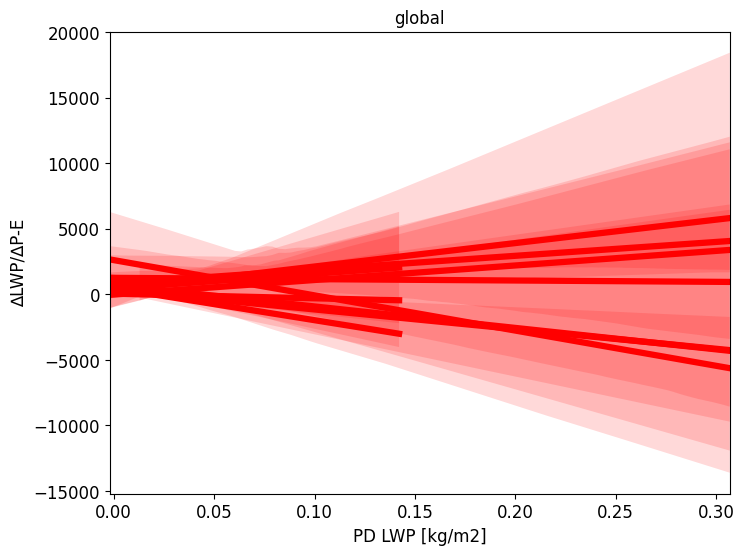

In [123]:
for i in range(10):
    plot_sns_linear(np.ravel(lwp_maps_o[i]), np.ravel(dLWPmap_o[i])/np.ravel(dPEmaps_o[i]))
    plt.xlabel('PD LWP [kg/m2]')
    plt.ylabel('∆LWP/∆P-E')
    plt.title('global')

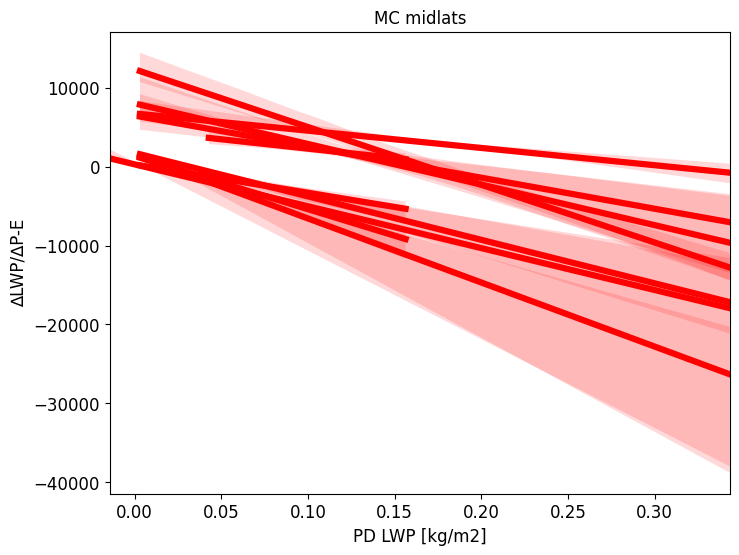

In [125]:
# Select latitude ranges separately and combine them
maps_o_sh = dPEmaps_o.sel(lat=slice(-80, -50))
maps_o_nh = dPEmaps_o.sel(lat=slice(50, 80))

# Concatenate the subsets along the latitude dimension
dPEmaps_o_midlats = xr.concat([maps_o_sh, maps_o_nh], dim="lat")

# common_members = np.intersect1d(lwp_maps_o_midlats['runs'], dLWPmap_o_midlats['runs'])
# lwp_maps_o_midlats = lwp_maps_o_midlats.sel(runs=common_members)
# dLWPmap_o_midlats = dLWPmap_o_midlats.sel(runs=common_members)

for i in range(10):
    plot_sns_linear(np.ravel(lwp_maps_o_midlats[i]), 
                    np.ravel(dLWPmap_o_midlats[i])/np.ravel(dPEmaps_o_midlats[i]))
    plt.xlabel('PD LWP [kg/m2]')
    plt.ylabel('∆LWP/∆P-E')
    plt.title('MC midlats')

# plot ∆LWP vs omega500(free running)
##### taking the mean maps for each ensemble

In [9]:
common_members = np.intersect1d(w500_maps_o['runs'], dLWPmap_o['runs'])

# Select only the common members from both datasets
w500_maps_o = w500_maps_o.sel(runs=common_members)
dLWPmap_o = dLWPmap_o.sel(runs=common_members)

Text(0.5, 1.0, 'global')

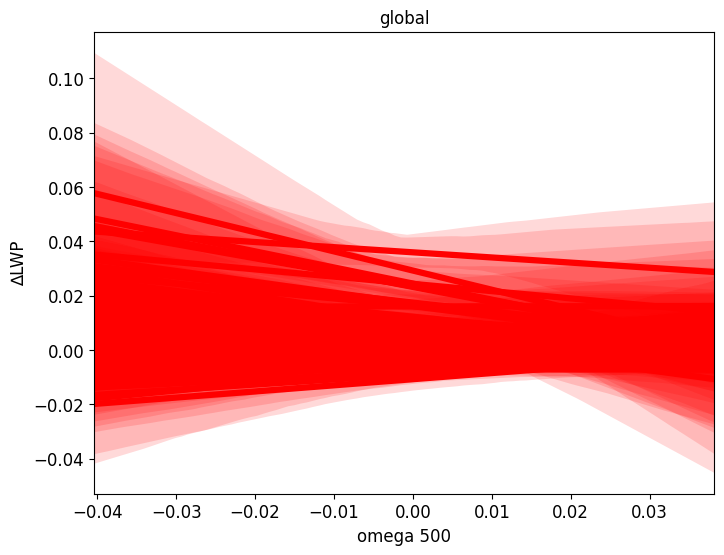

In [126]:
for i in range(len(w500_maps_o)): #
    r_squared, rmse, p_value = plot_sns_linear(np.ravel(w500_maps_o[i]), np.ravel(dLWPmap_o[i]), color='r')

plt.xlabel('omega 500')
plt.ylabel('∆LWP')
plt.title('global')

In [127]:
# Select latitude ranges separately and combine them
w500_maps_o_sh = w500_maps_o.sel(lat=slice(-80, -50))
w500_maps_o_nh = w500_maps_o.sel(lat=slice(50, 80))

# Concatenate the subsets along the latitude dimension
w500_maps_o_midlats = xr.concat([w500_maps_o_sh, w500_maps_o_nh], dim="lat")

In [128]:
# Select latitude ranges separately and combine them
dLWPmap_o_sh = dLWPmap_o.sel(lat=slice(-80, -50))
dLWPmap_o_nh = dLWPmap_o.sel(lat=slice(50, 80))

# Concatenate the subsets along the latitude dimension
dLWPmap_o_midlats = xr.concat([dLWPmap_o_sh, dLWPmap_o_nh], dim="lat")

Text(0.5, 1.0, 'for free runs in MC midlats')

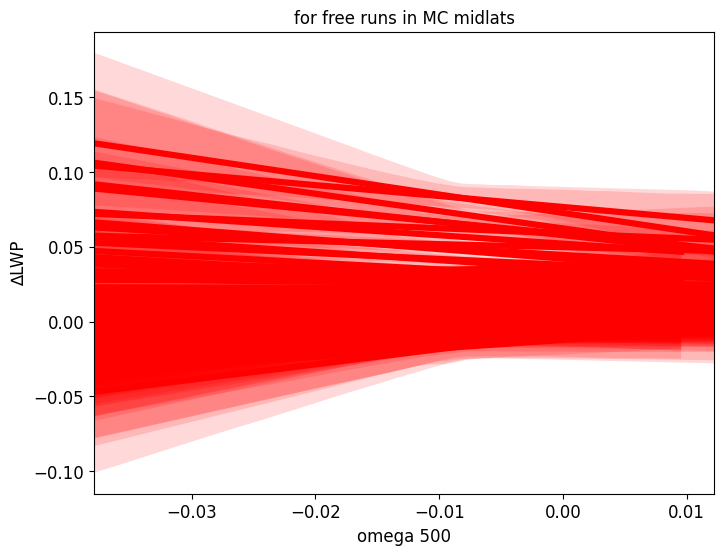

In [129]:
for i in range(len(w500_maps_o)): #
    r_squared, rmse, p_value = plot_sns_linear(np.ravel(w500_maps_o_midlats[i]),
                                               np.ravel(dLWPmap_o_midlats[i]), color='r')

plt.xlabel('omega 500')
plt.ylabel('∆LWP')
plt.title('for free runs in MC midlats')

# plot ∆LWP vs omega500(nudged)
##### taking the mean maps for each ensemble

In [14]:
from get_land_mask import get_land_mask
ensembles = []
w500_maps = []
w500_maps_o = []
ens = list(dLWPmean.runs.data.copy())
if 175 in ens:
    ens.remove(175)
for en in ens:
    print(en)
    Z, lat, lon,tt = get_nudged_PPE(en, varnm='OMEGA500')
    Z = np.nanmean(Z, axis=0)
    land_mask = get_land_mask(lat, lon)[0]
    w500_maps.append(Z)
    w500_maps_o.append(Z*land_mask)
    ensembles.append(en)
    # print(np.shape(w500_maps))
f_lat = lat
f_lon = lon

0
/glade/campaign/uwyo/wyom0124/daily/PD/PPE_rerun_ensemble_PD.000/atm/hist/PPE_rerun_ensemble_PD.000.cam.h1.*.nc
1
/glade/campaign/uwyo/wyom0124/daily/PD/PPE_rerun_ensemble_PD.001/atm/hist/PPE_rerun_ensemble_PD.001.cam.h1.*.nc
2
/glade/campaign/uwyo/wyom0124/daily/PD/PPE_rerun_ensemble_PD.002/atm/hist/PPE_rerun_ensemble_PD.002.cam.h1.*.nc
3
/glade/campaign/uwyo/wyom0124/daily/PD/PPE_rerun_ensemble_PD.003/atm/hist/PPE_rerun_ensemble_PD.003.cam.h1.*.nc
4
/glade/campaign/uwyo/wyom0124/daily/PD/PPE_rerun_ensemble_PD.004/atm/hist/PPE_rerun_ensemble_PD.004.cam.h1.*.nc
5
/glade/campaign/uwyo/wyom0124/daily/PD/PPE_rerun_ensemble_PD.005/atm/hist/PPE_rerun_ensemble_PD.005.cam.h1.*.nc
6
/glade/campaign/uwyo/wyom0124/daily/PD/PPE_rerun_ensemble_PD.006/atm/hist/PPE_rerun_ensemble_PD.006.cam.h1.*.nc
7
/glade/campaign/uwyo/wyom0124/daily/PD/PPE_rerun_ensemble_PD.007/atm/hist/PPE_rerun_ensemble_PD.007.cam.h1.*.nc
8
/glade/campaign/uwyo/wyom0124/daily/PD/PPE_rerun_ensemble_PD.008/atm/hist/PPE_rerun_en

In [ ]:
w500_maps = xr.DataArray(
    w500_maps,
    dims = ['runs', 'lat', 'lon'],
    coords={'runs': ensembles, 'lat': f_lat, 'lon': f_lon}
)

In [ ]:
w500_maps_o = xr.DataArray(
    w500_maps_o,
    dims = ['runs', 'lat', 'lon'],
    coords={'runs': ensembles, 'lat': f_lat, 'lon': f_lon}
)

In [15]:
common_members = np.intersect1d(w500_maps_o['runs'], dLWPmap_o['runs'])

# Select only the common members from both datasets
w500_maps_o = w500_maps_o.sel(runs=common_members)
dLWPmap_o = dLWPmap_o.sel(runs=common_members)

TypeError: list indices must be integers or slices, not str

In [ ]:
for i in range(len(w500_maps_o)): #
    r_squared, rmse, p_value = plot_sns_linear(np.ravel(w500_maps_o[i]), np.ravel(dLWPmap_o[i]), color='r')

plt.xlabel('omega 500')
plt.ylabel('∆LWP')
plt.title('for nudged runs')

# ∆LWP vs w500(nudged)
#### for midlatitudes both hemispheres (50-80)

In [10]:
# Select latitude ranges separately and combine them
w500_maps_o_sh = w500_maps_o.sel(lat=slice(-80, -50))
w500_maps_o_nh = w500_maps_o.sel(lat=slice(50, 80))

# Concatenate the subsets along the latitude dimension
w500_maps_o_midlats = xr.concat([w500_maps_o_sh, w500_maps_o_nh], dim="lat")

In [11]:
# Select latitude ranges separately and combine them
dLWPmap_o_sh = dLWPmap_o.sel(lat=slice(-80, -50))
dLWPmap_o_nh = dLWPmap_o.sel(lat=slice(50, 80))

# Concatenate the subsets along the latitude dimension
dLWPmap_o_midlats = xr.concat([dLWPmap_o_sh, dLWPmap_o_nh], dim="lat")

Text(0.5, 1.0, 'for nudged runs in converging midlats')

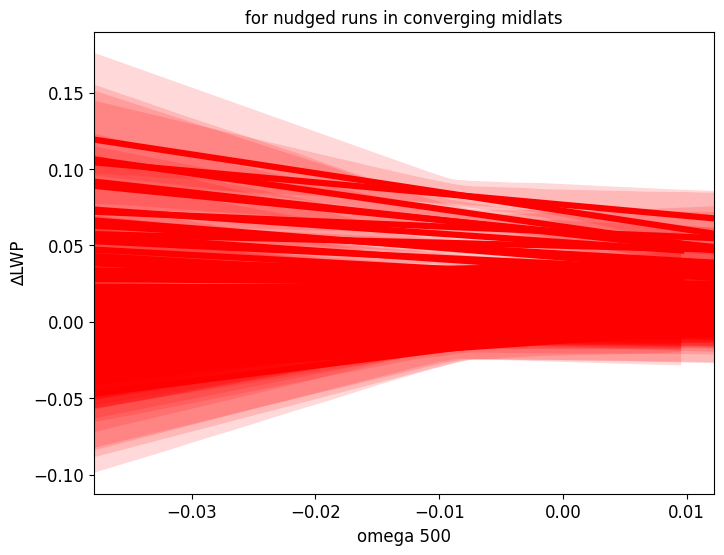

In [12]:
for i in range(len(w500_maps_o)): #
    r_squared, rmse, p_value = plot_sns_linear(np.ravel(w500_maps_o_midlats[i]), np.ravel(dLWPmap_o_midlats[i]), color='r')

plt.xlabel('omega 500')
plt.ylabel('∆LWP')
plt.title('for nudged runs in converging midlats')

# w500 - wvp - ∆LWP

In [54]:
# w500_maps_o

In [52]:
file = np.load('data/PD_freeRun_wvp_maps_o.npz')
# convert np array to xarrays
wvp_maps_o = xr.DataArray(
    file['maps_o'], 
    dims = ['runs', 'lat', 'lon'],
    coords={'runs': file['runs'], 
            'lat': file['lat'], 
            'lon': file['lon']}
)

In [56]:
# dLWPmap_o

In [67]:
common_members = np.intersect1d(w500_maps_o['runs'], dLWPmap_o['runs'])

# Select only the common members from both datasets
w500_maps_o = w500_maps_o.sel(runs=common_members)
dLWPmap_o = dLWPmap_o.sel(runs=common_members)
wvp_maps_o = wvp_maps_o.sel(runs=common_members)

In [143]:
'get the 2D binned statistic'
### get the 2D binned statistic
### (x, y, z - all in 1D array)
def twodbin(x_95, y_95, z_95, bins=[10,12], n_bins=10, bin_range=[[-0.06, 0.06], [5, 50]]):
    ind = np.isnan(x_95*y_95*z_95)==False
    bins_cnt = stats.binned_statistic_2d(y_95[ind], x_95[ind], z_95[ind], 
                                         bins=bins, statistic='count', range=bin_range)[0]
    bins = stats.binned_statistic_2d(y_95[ind], x_95[ind], z_95[ind], 
                                     bins=bins, range=bin_range)
    
    y_f = list(reversed(find_midpoints(bins[1]))) #length 10
    x_f = find_midpoints(bins[2]) #length 12
    z_f = list(reversed(bins[0]))
    z_f = np.array(z_f)
    c = list(reversed(bins_cnt))
    c = np.array(c)
    c_ind = np.where(c<n_bins)
    c[c_ind] = np.nan
    z_f[c_ind] = np.nan
    return x_f, y_f, z_f, c

def find_midpoints(bins):
    midpoints = (bins[:-1] + bins[1:]) / 2
    return midpoints


In [78]:
en = 0
x = np.ravel(wvp_maps_o[en].data)
y = np.ravel(w500_maps_o[en].data)
z = np.ravel(dLWPmap_o[en].data)

In [79]:
h_wvp, h_omg, h_dlwp, h_c = twodbin(x, y, z, bins=[10,12], n_bins=100)

Text(0.5, 1.0, 'global')

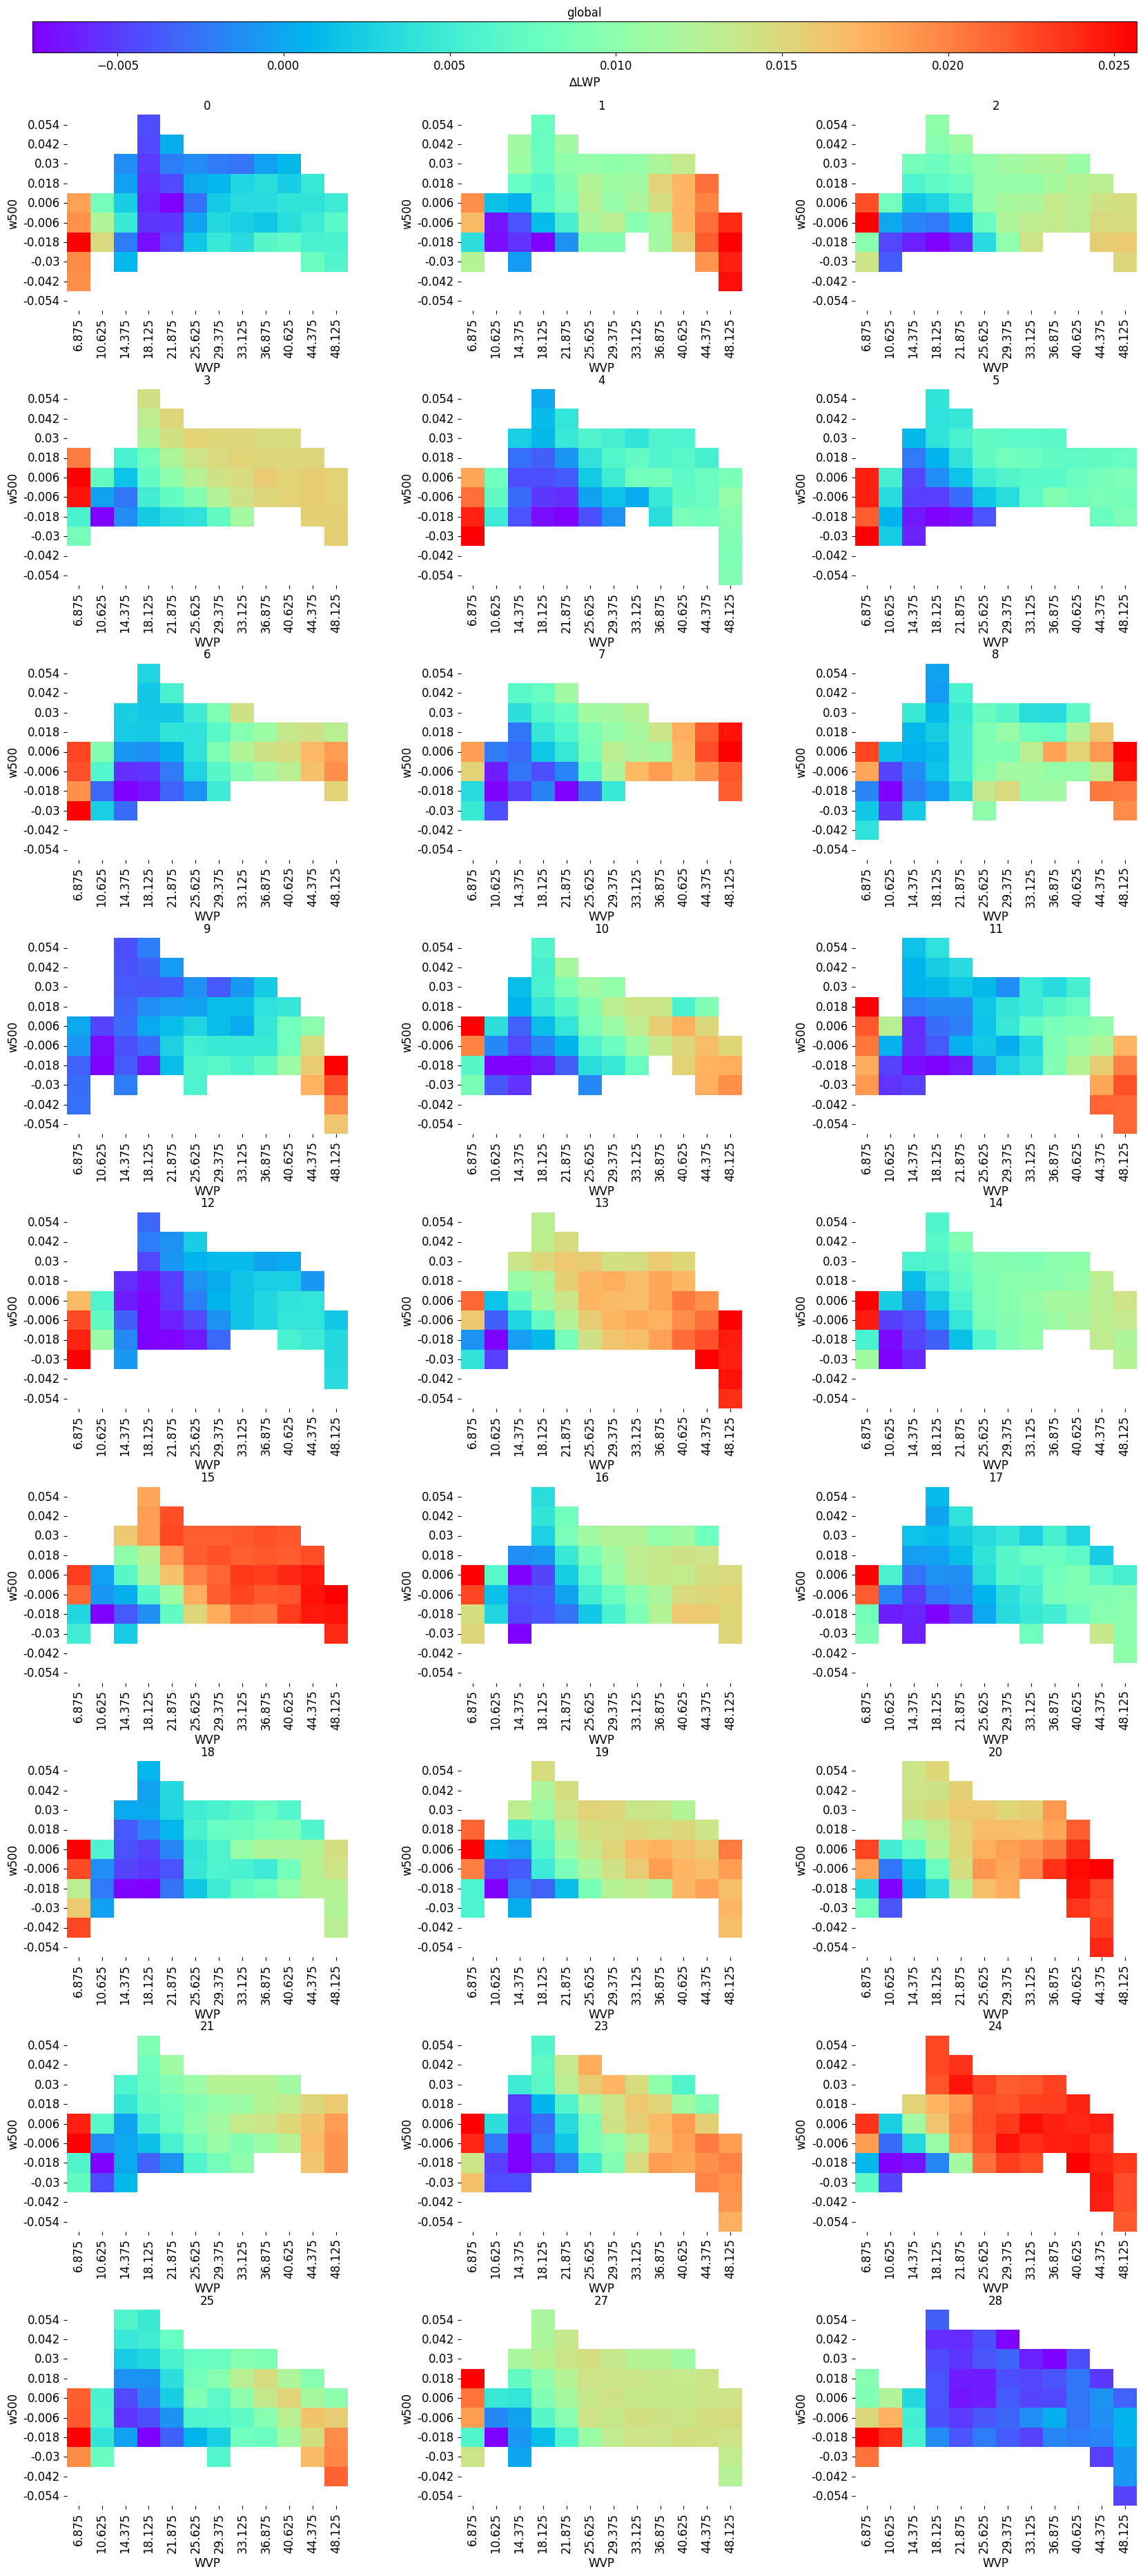

In [145]:
# Create a 9x3 grid of subplots
fig, axs = plt.subplots(9, 3, figsize=(20, 45))

# Iterate over each subplot and plot your data
for en, ax in enumerate(axs.flat):
    x = np.ravel(wvp_maps_o[en].data)
    y = np.ravel(w500_maps_o[en].data)
    z = np.ravel(dLWPmap_o[en].data)
    h_wvp, h_omg, h_dlwp, h_c = twodbin(x, y, z, bins=[10,12], 
                                        n_bins=100, 
                                        bin_range=[[-0.06, 0.06], [5, 50]])
    sns.heatmap(h_dlwp, 
                xticklabels=np.round(h_wvp,4), 
                yticklabels=np.round(h_omg,4), 
                cmap="rainbow", ax=ax,
                cbar=False)

    ax.set_title(w500_maps_o.runs.data[en])
    ax.set_xlabel('WVP')
    ax.set_ylabel('w500')

# Create a separate axes for the colorbar
cax = fig.add_axes([0.1, 0.9, 0.8, 0.01])  # [left, bottom, width, height]

# Plot a colorbar using a sample mappable object (you should replace it with your own)
cb = plt.colorbar(axs[0, 0].collections[0], cax=cax, orientation='horizontal')
cb.set_label('∆LWP')  # Set the label for the colorbar

# Increase the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust these values as needed

plt.title('global')

# plt.savefig('revised_figures/models_u10_heatmap_both.png',
#             bbox_inches='tight',facecolor='white',dpi=500)

In [146]:
# Select latitude ranges separately and combine them
maps_o_sh = wvp_maps_o.sel(lat=slice(-80, -50))
maps_o_nh = wvp_maps_o.sel(lat=slice(50, 80))

# Concatenate the subsets along the latitude dimension
wvp_maps_o_midlats = xr.concat([maps_o_sh, maps_o_nh], dim="lat")

Text(0.5, 1.0, 'MC midlats')

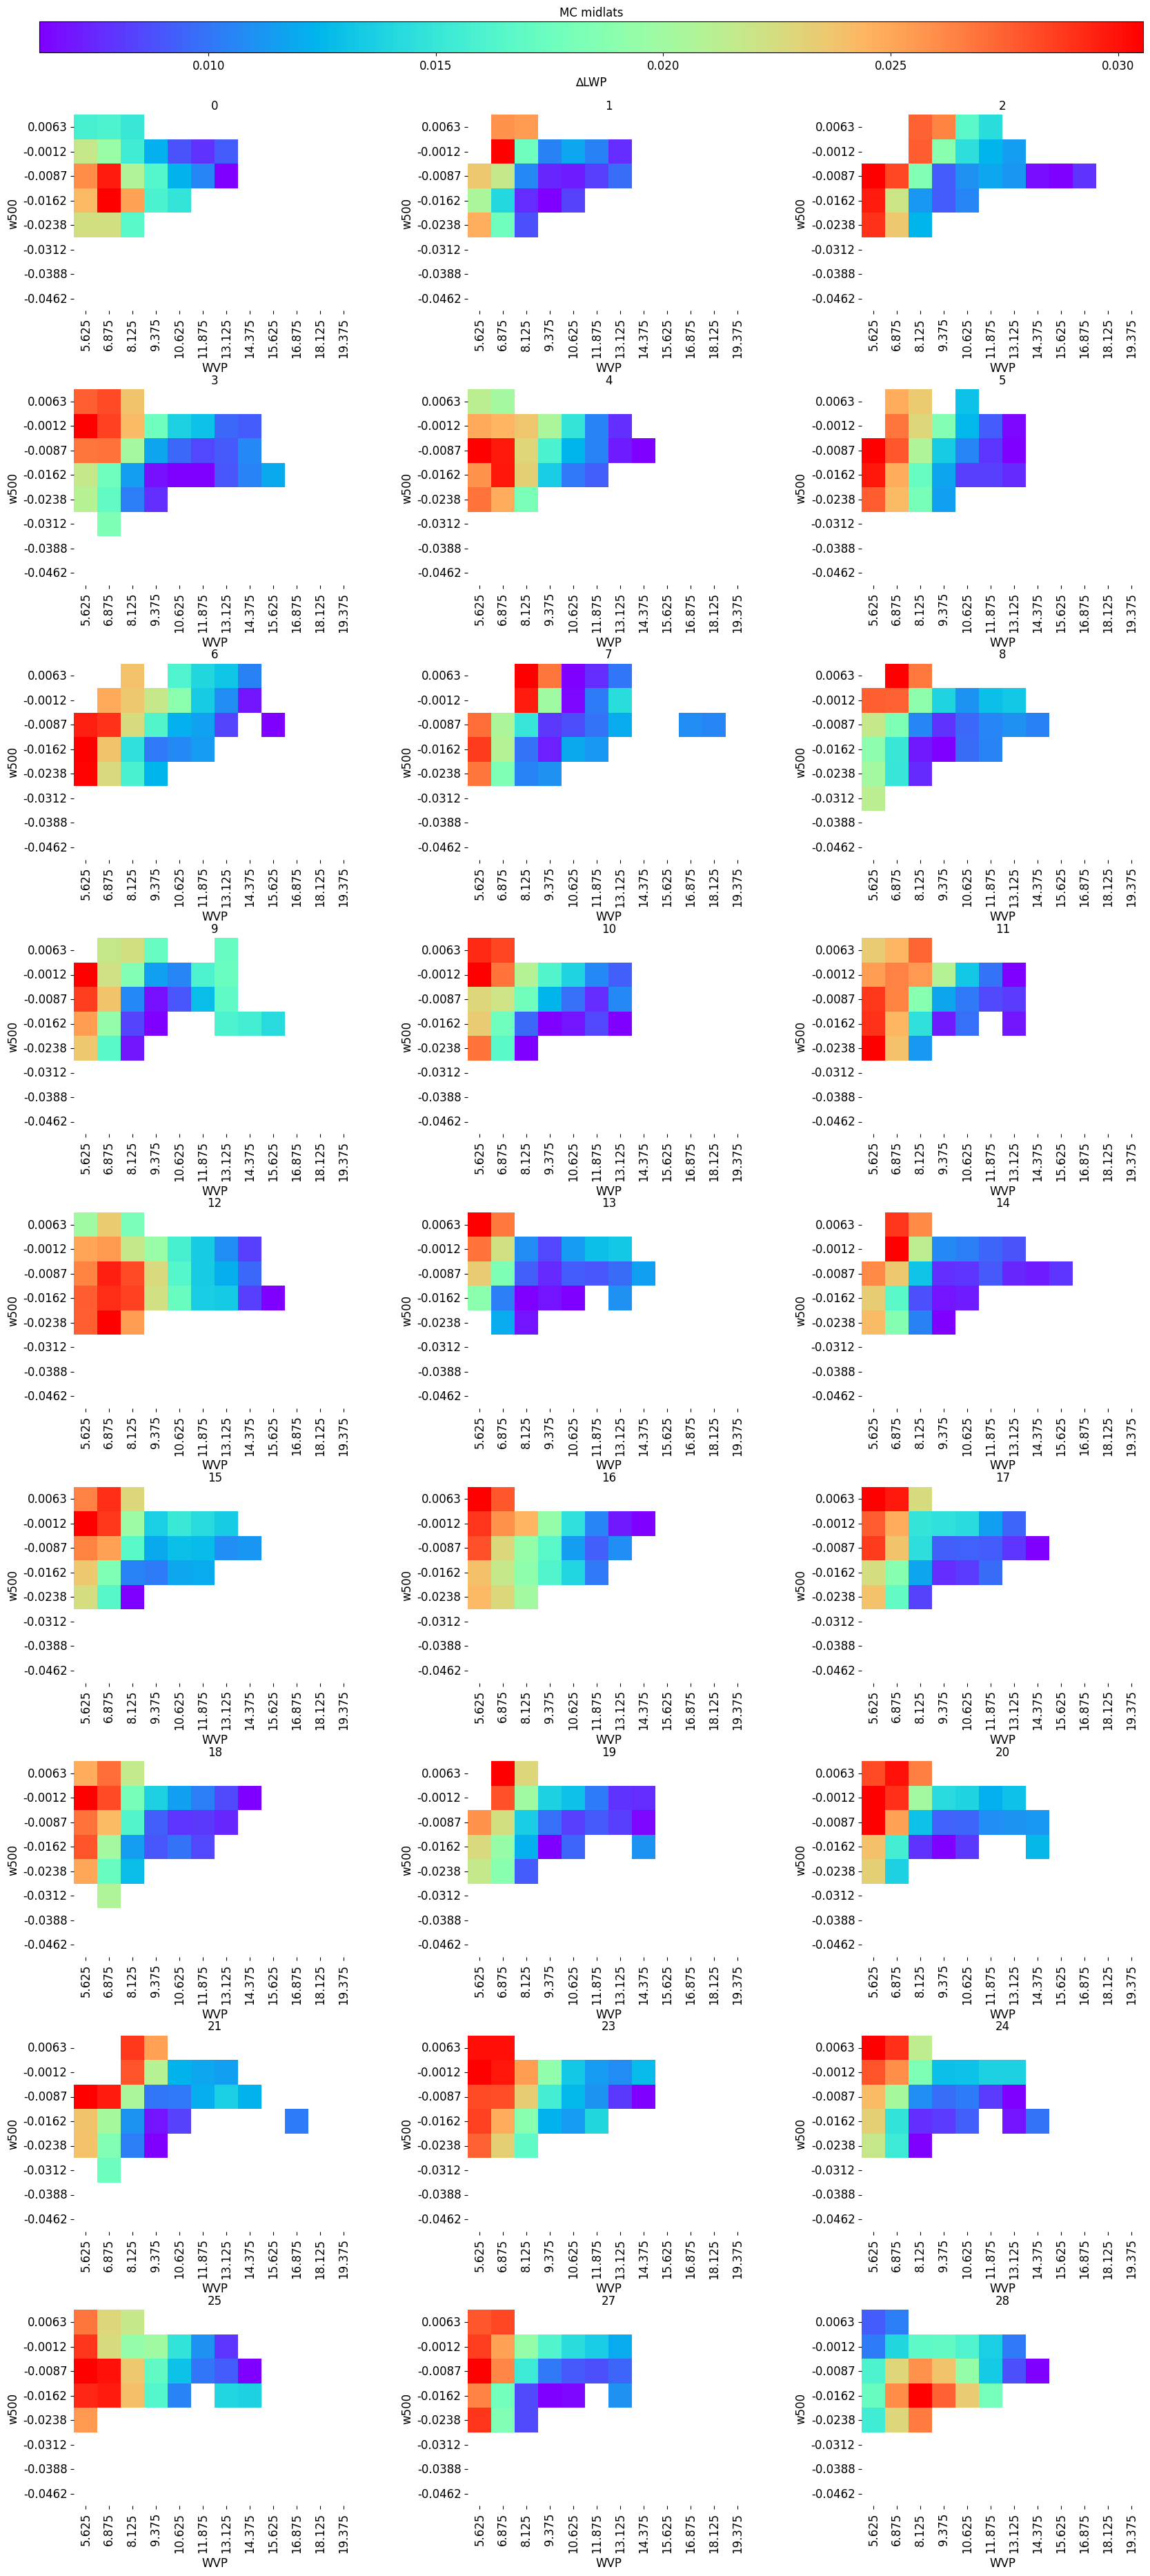

In [163]:
# Create a 9x3 grid of subplots
fig, axs = plt.subplots(9, 3, figsize=(20, 45))

# Iterate over each subplot and plot your data
for en, ax in enumerate(axs.flat):
    x = np.ravel(wvp_maps_o_midlats[en].data)
    y = np.ravel(w500_maps_o_midlats[en].data)
    z = np.ravel(dLWPmap_o_midlats[en].data)
    h_wvp, h_omg, h_dlwp, h_c = twodbin(x, y, z, bins=[8,12], n_bins=100, bin_range=[[-0.05, 0.01], [5, 20]])
    sns.heatmap(h_dlwp, 
                xticklabels=np.round(h_wvp,4), 
                yticklabels=np.round(h_omg,4), 
                cmap="rainbow", ax=ax,
                cbar=False)

    ax.set_title(w500_maps_o.runs.data[en])
    ax.set_xlabel('WVP')
    ax.set_ylabel('w500')

# Create a separate axes for the colorbar
cax = fig.add_axes([0.1, 0.9, 0.8, 0.01])  # [left, bottom, width, height]

# Plot a colorbar using a sample mappable object (you should replace it with your own)
cb = plt.colorbar(axs[0, 0].collections[0], cax=cax, orientation='horizontal')
cb.set_label('∆LWP')  # Set the label for the colorbar

# Increase the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust these values as needed

plt.title('MC midlats')

# plt.savefig('revised_figures/models_u10_heatmap_both.png',
#             bbox_inches='tight',facecolor='white',dpi=500)

In [148]:
# Select latitude ranges separately and combine them
wvp_maps_o_sh = wvp_maps_o.sel(lat=slice(-80, -50))
w500_maps_o_sh = w500_maps_o.sel(lat=slice(-80, -50))
dLWPmap_o_sh = dLWPmap_o_sh.sel(lat=slice(-80, -50))

Text(0.5, 1.0, 'MC SH')

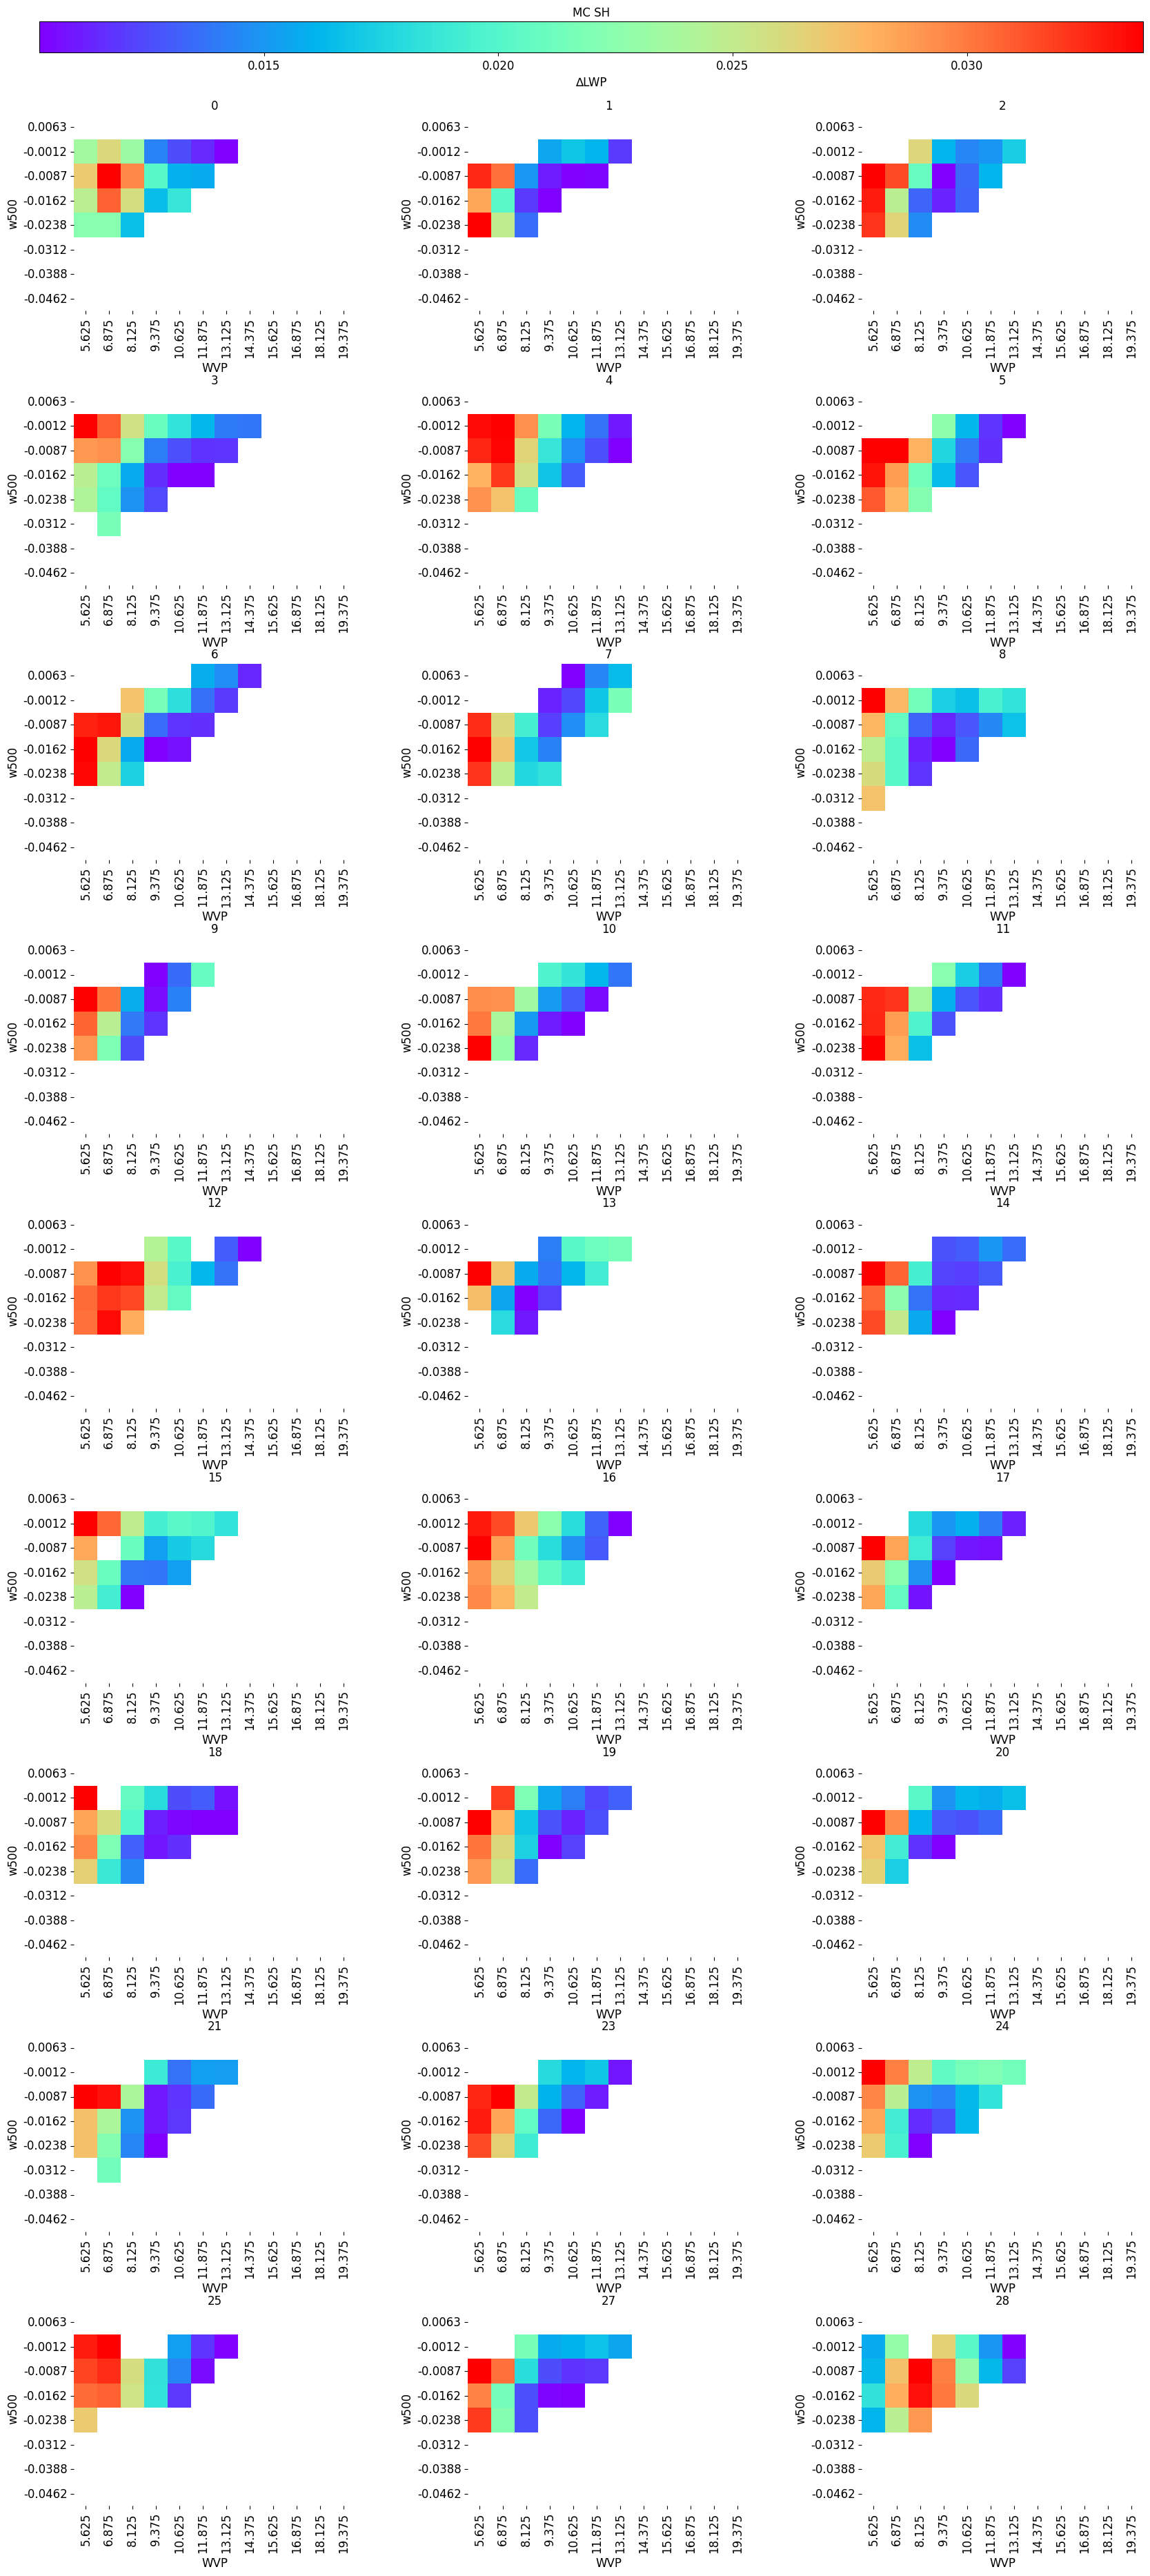

In [162]:
# Create a 9x3 grid of subplots
fig, axs = plt.subplots(9, 3, figsize=(20, 45))

# Iterate over each subplot and plot your data
for en, ax in enumerate(axs.flat):
    x = np.ravel(wvp_maps_o_sh[en].data)
    y = np.ravel(w500_maps_o_sh[en].data)
    z = np.ravel(dLWPmap_o_sh[en].data)
    h_wvp, h_omg, h_dlwp, h_c = twodbin(x, y, z, bins=[8,12], n_bins=100, bin_range=[[-0.05, 0.01], [5, 20]])
    sns.heatmap(h_dlwp, 
                xticklabels=np.round(h_wvp,4), 
                yticklabels=np.round(h_omg,4), 
                cmap="rainbow", ax=ax,
                cbar=False)

    ax.set_title(w500_maps_o.runs.data[en])
    ax.set_xlabel('WVP')
    ax.set_ylabel('w500')

# Create a separate axes for the colorbar
cax = fig.add_axes([0.1, 0.9, 0.8, 0.01])  # [left, bottom, width, height]

# Plot a colorbar using a sample mappable object (you should replace it with your own)
cb = plt.colorbar(axs[0, 0].collections[0], cax=cax, orientation='horizontal')
cb.set_label('∆LWP')  # Set the label for the colorbar

# Increase the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust these values as needed

plt.title('MC SH')

# plt.savefig('revised_figures/models_u10_heatmap_both.png',
#             bbox_inches='tight',facecolor='white',dpi=500)

# w500 - wvp - ∆LWP : ensemble means

In [151]:
wvp_mean_ml = lat_weight_mean(wvp_maps_o_midlats)
w500_mean_ml = lat_weight_mean(w500_maps_o_midlats)
dlwp_mean_ml = lat_weight_mean(dLWPmap_o_midlats)

In [154]:
np.shape(dlwp_mean_ml)

(253,)

Text(0, 0.5, 'w500')

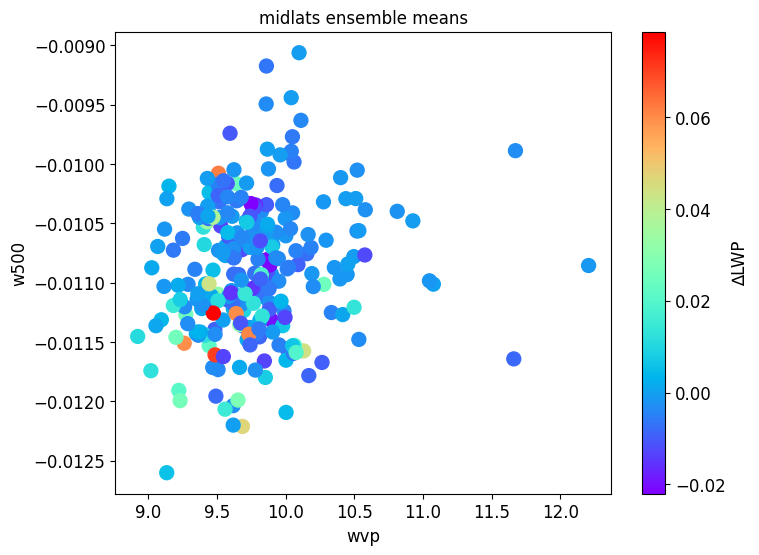

In [164]:
plt.scatter(wvp_mean_ml, w500_mean_ml, 
            c=dlwp_mean_ml, 
            cmap='rainbow', s=100)
plt.colorbar(label='∆LWP')
plt.title('midlats ensemble means')
plt.xlabel('wvp')
plt.ylabel('w500')

# w500 - PE - ∆LWP : ensemble means

In [168]:
file = np.load('/glade/u/home/geethma/phd_research_home/PPE_emulator/grad_LWP_WCB_SH_summer_moisteningLats_new.npz')
# convert np array to xarrays
PPE_grad_LWP_WCB = xr.DataArray(
    file['grad_LWP_WCB'],
    dims=['runs'],
    coords={'runs': file['runs']}
)

In [169]:
common_members = np.intersect1d(w500_maps_o['runs'], PPE_grad_LWP_WCB['runs'])

# Select only the common members from both datasets
PPE_grad_LWP_WCB = PPE_grad_LWP_WCB.sel(runs=common_members)
# dLWPmap_o = dLWPmap_o.sel(runs=common_members)
# wvp_maps_o = wvp_maps_o.sel(runs=common_members)

Text(0, 0.5, 'w500')

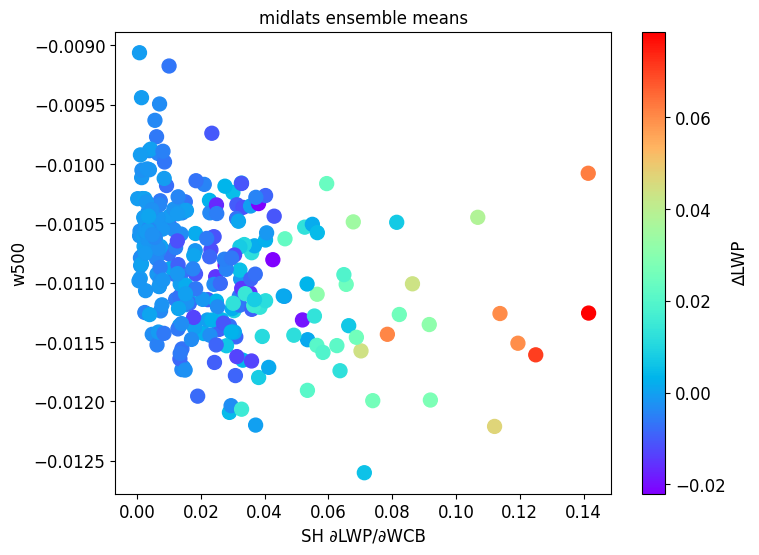

In [170]:
plt.scatter(PPE_grad_LWP_WCB, w500_mean_ml, 
            c=dlwp_mean_ml, 
            cmap='rainbow', s=100)
plt.colorbar(label='∆LWP')
plt.title('midlats ensemble means')
plt.xlabel('SH ∂LWP/∂WCB')
plt.ylabel('w500')

# PE with w500

# S